In [20]:
%matplotlib inline
import pandas as pd
import numpy as np
from fbprophet import Prophet
import math
import seaborn as sns

## Load your csv into a dataframe
### Note: your csv must have a date (yyyy-mm-dd format) column with the column name 'ds' and the variable you want to forecast with the column name 'y'

In [21]:
input_path = '/Users/adleyhemphill/Documents/learner_baseline_forecast_csv.csv'
output_path = '/Users/adleyhemphill/Documents/learner_baseline_forecast_csv_output2.csv'

In [22]:
df = pd.read_csv(input_path)
#df = df.drop(df.index[df.y==0])
#df['y'] = np.log(df['y'])

In [23]:
df.head(20)

,ds,overall_sessions,new_sessions,new_sessions_w_out_rubicon,pct_new_sessions,enrollments,registrations,enroll_conversion,reg_conversion,reg_conv_w_out_rubicon
0,2014-05-20,82209.0,38765.0,47070.45,0.471542,45659,4314,0.555401,0.111286,0.091650
1,2014-05-21,162955.0,71524.0,103067.60,0.438919,12754,4445,0.078267,0.062147,0.043127
2,2014-05-22,164488.0,74962.0,99821.45,0.455729,13501,4944,0.082079,0.065953,0.049528
3,2014-05-23,158422.0,74762.0,101444.95,0.471917,12737,5073,0.080399,0.067855,0.050007
4,2014-05-24,123214.0,52811.0,71417.00,0.428612,9515,2733,0.077223,0.051751,0.038268
5,2014-05-25,136237.0,57977.0,86025.10,0.425560,9442,2753,0.069306,0.047484,0.032002
6,2014-05-26,155453.0,63325.0,100633.20,0.407358,11161,3610,0.071797,0.057008,0.035873
7,2014-05-27,307544.0,113532.0,159065.60,0.369157,38686,5186,0.125790,0.045679,0.032603
8,2014-05-28,207320.0,76921.0,114429.55,0.371025,22485,4639,0.108456,0.060309,0.040540
9,2014-05-29,188793.0,74081.0,94952.65,0.392393,16966,5420,0.089866,0.073163,0.057081


## Set training parameters

In [30]:
forecast_metrics = [
# 'reg_conversion',
# 'enroll_conversion',
# 'overall_sessions',
# 'new_sessions'
'new_sessions_w_out_rubicon',
'reg_conv_w_out_rubicon'
]

cap_scenario = np.arange(-0.50, 0.5, 0.10)

cap_retro_days = 365

forecast_period = 365*3

## Train the model and forecast based on params set above

In [31]:
master_forecast = pd.DataFrame()

for i in forecast_metrics:
    for j in cap_scenario:
                
        m = Prophet(growth='logistic')

        temp = pd.DataFrame(df['ds'])
        temp['y'] = df[i]
        
#         cap = temp.tail(cap_retro_days)['y'].median()       
#         cap = cap + (cap * j)          

# calculate the growth cap_retro_days over cap_retro_days
# use that as baseline growth assumption
# adjust by values in cap_scenario
# project new growth cap number and forecast

        n = temp.tail(cap_retro_days).y.median()
        n_minus_1 = temp[(-cap_retro_days*2):-cap_retro_days].y.median()
        pct_growth = (n-n_minus_1)/n_minus_1
        pct_growth_adj = pct_growth + (pct_growth * j)
        cap = n + (n * pct_growth_adj)
        
        temp['cap'] = cap
        
        m.fit(temp)
        future = m.make_future_dataframe(periods = forecast_period)
        future['cap'] = cap
        forecast = m.predict(future)
        
        temp_forecast = pd.DataFrame()
        temp_forecast = forecast[['ds', 'yhat']]
        temp_forecast['metric'] = i
        temp_forecast['growth_factor'] = j
        temp_forecast['pct_growth'] = pct_growth_adj
        
        master_forecast = master_forecast.append(temp_forecast)
        #m.plot(forecast)
        #m.plot_components(forecast)

/Users/adleyhemphill/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/adleyhemphill/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/adleyhemphill/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.py

In [32]:
master_forecast#.metric.unique()

,ds,yhat,metric,growth_factor,pct_growth
0,2014-05-20,75137.804500,new_sessions_w_out_rubicon,-0.5,-0.038834
1,2014-05-21,74945.791357,new_sessions_w_out_rubicon,-0.5,-0.038834
2,2014-05-22,70749.410480,new_sessions_w_out_rubicon,-0.5,-0.038834
3,2014-05-23,62990.989211,new_sessions_w_out_rubicon,-0.5,-0.038834
4,2014-05-24,48415.728142,new_sessions_w_out_rubicon,-0.5,-0.038834
5,2014-05-25,54583.181263,new_sessions_w_out_rubicon,-0.5,-0.038834
6,2014-05-26,74785.359399,new_sessions_w_out_rubicon,-0.5,-0.038834
7,2014-05-27,88683.758647,new_sessions_w_out_rubicon,-0.5,-0.038834
8,2014-05-28,88679.545798,new_sessions_w_out_rubicon,-0.5,-0.038834
9,2014-05-29,84457.128121,new_sessions_w_out_rubicon,-0.5,-0.038834


In [33]:

for i in forecast_metrics:
               
        m = Prophet()

        temp = pd.DataFrame(df['ds'])
        temp['y'] = df[i]
        
#         cap = temp.tail(cap_retro_days)['y'].median()       
#         cap = cap + (cap * j)          

# calculate the growth cap_retro_days over cap_retro_days
# use that as baseline growth assumption
# adjust by values in cap_scenario
# project new growth cap number and forecast

#         n = temp.tail(cap_retro_days).y.median()
#         n_minus_1 = temp[(-cap_retro_days*2):-cap_retro_days].y.median()
#         pct_growth = (n-n_minus_1)/n_minus_1
#         pct_growth_adj = pct_growth + (pct_growth * j)
#         cap = n + (n * pct_growth_adj)
        
#         temp['cap'] = cap
        
        m.fit(temp)
        future = m.make_future_dataframe(periods = forecast_period)
#         future['cap'] = cap
        forecast = m.predict(future)
        
        temp_forecast = pd.DataFrame()
        temp_forecast = forecast[['ds', 'yhat']]
        temp_forecast['metric'] = i
        temp_forecast['growth_factor'] = 'linear'
        temp_forecast['pct_growth'] = 'linear'
        
        master_forecast = master_forecast.append(temp_forecast)
        #m.plot(forecast)
        #m.plot_components(forecast)

/Users/adleyhemphill/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/adleyhemphill/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/adleyhemphill/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.py

In [34]:
master_forecast
#master_forecast[(master_forecast['ds']>='2017-07-01') & (master_forecast['ds']<'2018-07-01')].groupby('metric').sum()

,ds,yhat,metric,growth_factor,pct_growth
0,2014-05-20,75137.804500,new_sessions_w_out_rubicon,-0.5,-0.0388339
1,2014-05-21,74945.791357,new_sessions_w_out_rubicon,-0.5,-0.0388339
2,2014-05-22,70749.410480,new_sessions_w_out_rubicon,-0.5,-0.0388339
3,2014-05-23,62990.989211,new_sessions_w_out_rubicon,-0.5,-0.0388339
4,2014-05-24,48415.728142,new_sessions_w_out_rubicon,-0.5,-0.0388339
5,2014-05-25,54583.181263,new_sessions_w_out_rubicon,-0.5,-0.0388339
6,2014-05-26,74785.359399,new_sessions_w_out_rubicon,-0.5,-0.0388339
7,2014-05-27,88683.758647,new_sessions_w_out_rubicon,-0.5,-0.0388339
8,2014-05-28,88679.545798,new_sessions_w_out_rubicon,-0.5,-0.0388339
9,2014-05-29,84457.128121,new_sessions_w_out_rubicon,-0.5,-0.0388339


In [35]:
master_forecast.to_csv(output_path)

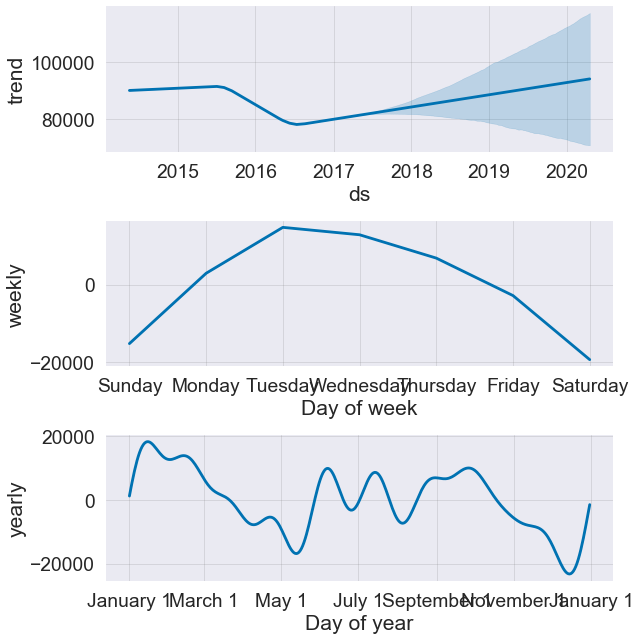

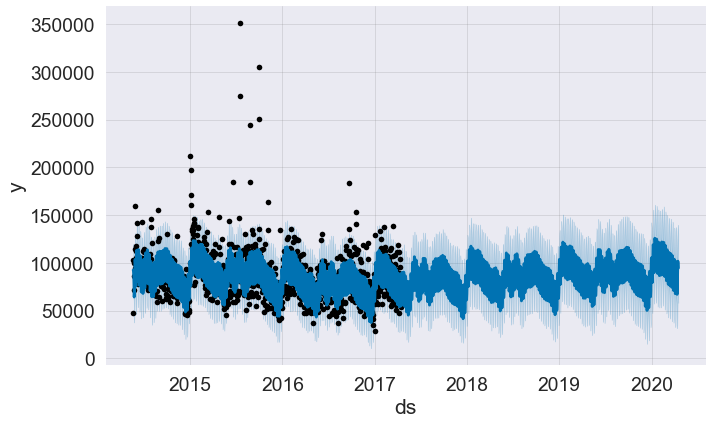

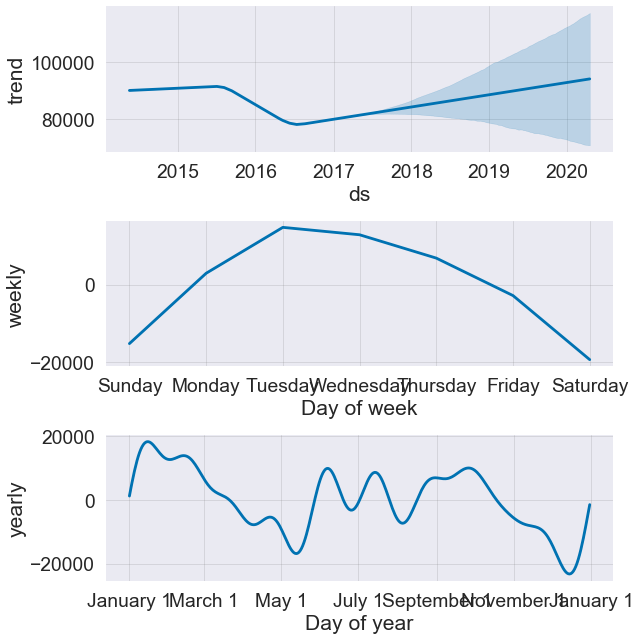

In [39]:
m = Prophet(growth='linear')

temp = pd.DataFrame(df['ds'])
temp['y'] = df['new_sessions_w_out_rubicon']

#temp['cap'] = 20

m.fit(temp)
future = m.make_future_dataframe(periods = forecast_period)
#future['cap'] = 20
forecast = m.predict(future)
m.plot(forecast)
m.plot_components(forecast)

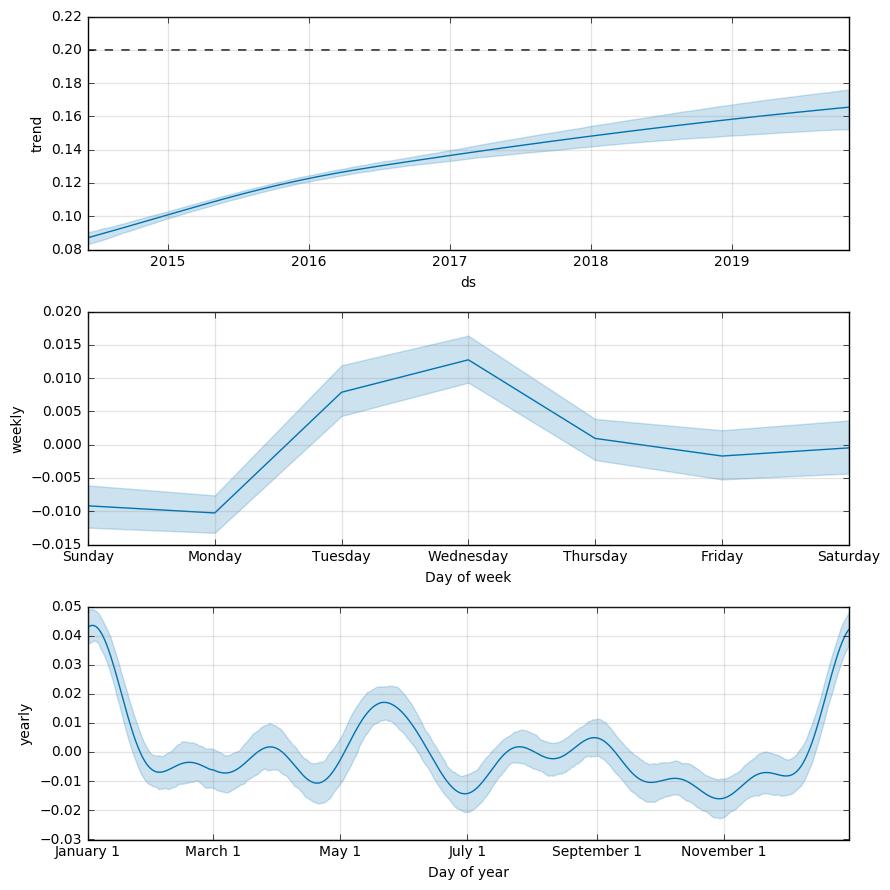

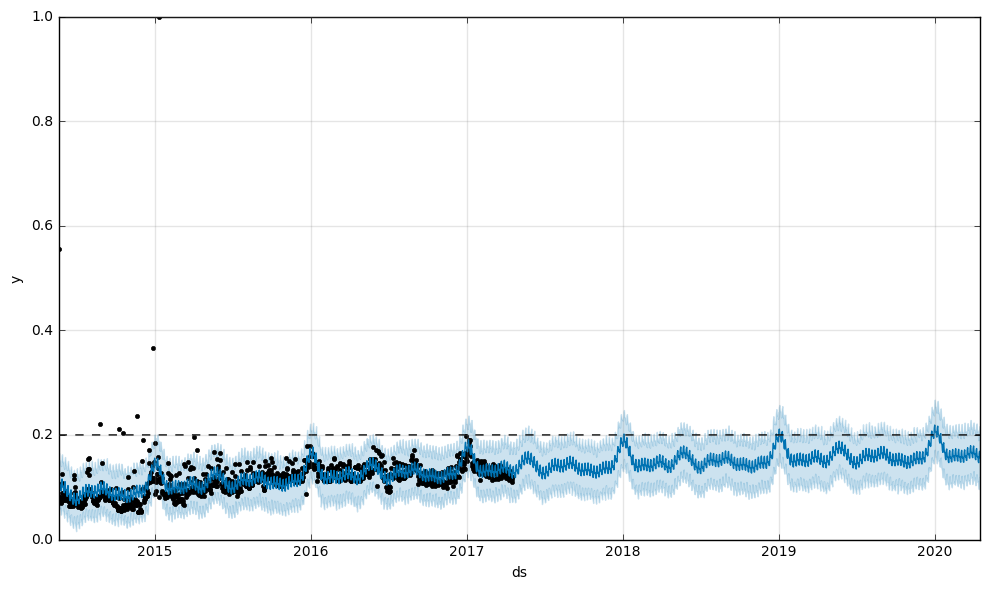

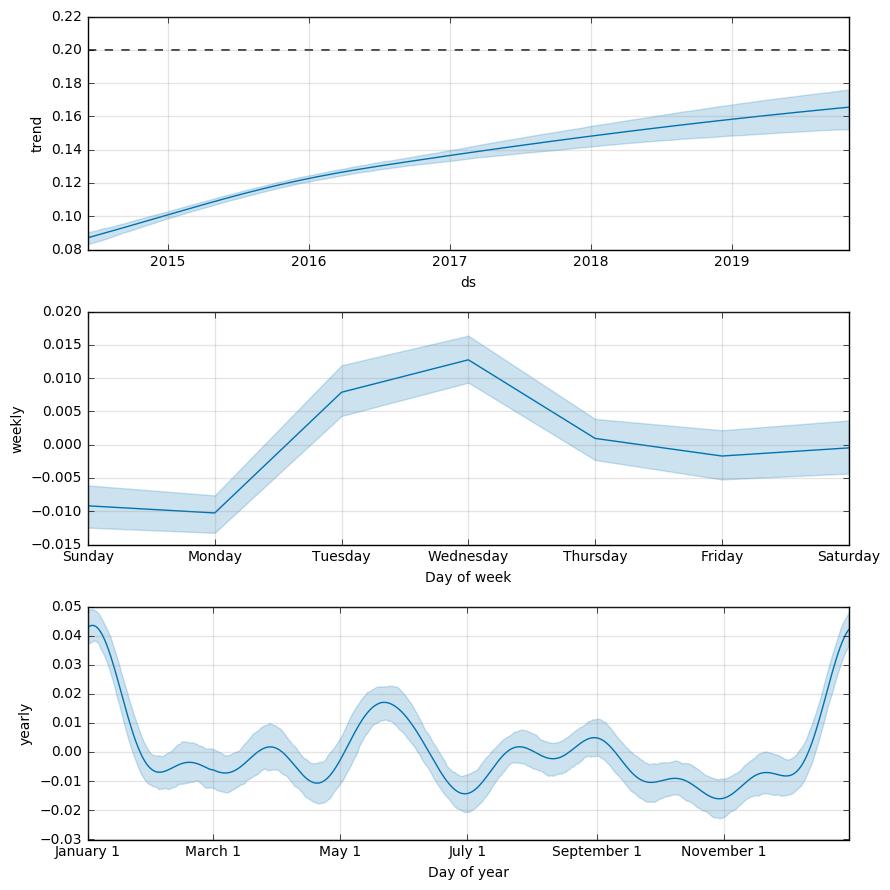

In [201]:

m = Prophet(growth='logistic', mcmc_samples=500)

temp = pd.DataFrame(df['ds'])
temp['y'] = df['enroll_conversion']

temp['cap'] = 0.2

m.fit(temp)
future = m.make_future_dataframe(periods = forecast_period)
future['cap'] = 0.2
forecast = m.predict(future)

# temp_forecast = pd.DataFrame()
# temp_forecast = forecast[['ds', 'yhat']]
# temp_forecast['metric'] = i
# temp_forecast['growth_factor'] = j
# temp_forecast['pct_growth'] = pct_growth_adj

#master_forecast2 = master_forecast.append(temp_forecast)
m.plot(forecast)
m.plot_components(forecast)

In [200]:
forecast[(forecast['ds']>='2017-07-01') & (forecast['ds']<'2018-07-01')]['yhat'].mean()

0.1489595266007406

In [4]:
plot_df = pd.read_csv('/Users/adleyhemphill/Documents/fy18_baseline_incremental.csv')

In [5]:
plot_df.head()

,item,value,value_cumulative
0,baseline,19.53,19.53
1,i18n,1.09,20.62
2,engagement_growth,3.45,24.07
3,MM/PC,5.60,29.67


In [8]:
colors = ["windows blue", "amber", "greyish", "faded green", "dusty purple"]
xkcd = sns.xkcd_palette(colors)
sns.set_context("poster", font_scale=1.2)

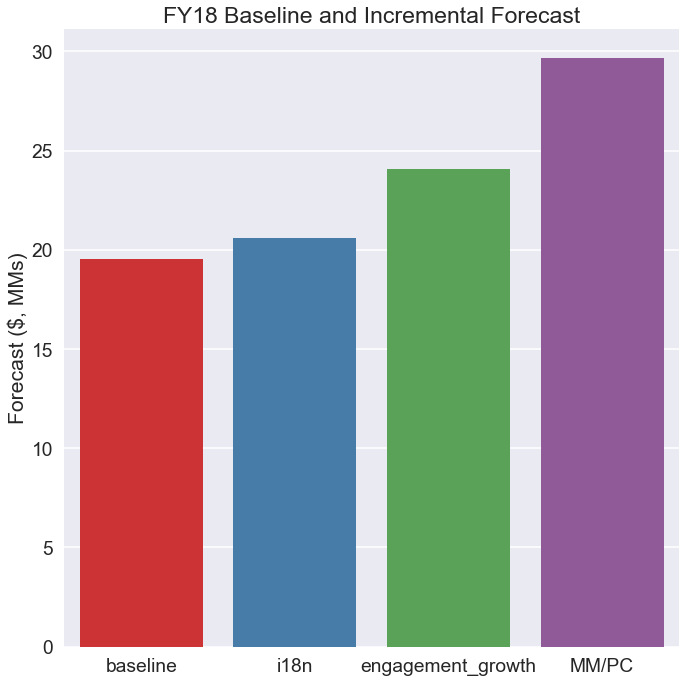

In [18]:
ax = sns.factorplot(data = plot_df, x='item', 
               y='value_cumulative', 
               kind='bar',
              size = 10,
              palette='Set1')
ax.set(title = 'FY18 Baseline and Incremental Forecast',
      ylabel = 'Forecast ($, MMs)',
      xlabel = '')